In [57]:
import sys
sys.path.append('../../code')
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns
from sbi import inference as sbi_inference
from utils import (linear_scale_array, UniformPrior,
                   get_dataset_psd, get_dataset_peaks, load_posterior, simulator_hnn,
                   get_parameter_recovery, get_posterior_predictive_check, hnn_beta_param_function)
from hnn_core import jones_2009_model
from functools import partial
import dill
from sbi import utils as sbi_utils
import pandas as pd
from sklearn.decomposition import PCA
from scipy.io import loadmat
from scipy.interpolate import CubicSpline
from hnn_core.utils import smooth_waveform
rng_seed = 123

scale_factor = 60_000

sns.set()
sns.set_style("white")

device = 'cpu'

sim_type = 'hnn_beta'
data_path = f'../../data/{sim_type}'

with open(f'{data_path}/posteriors/posterior_dicts.pkl', 'rb') as output_file:
    posterior_state_dicts = dill.load(output_file)
with open(f'{data_path}/sbi_sims/prior_dict.pkl', 'rb') as output_file:
    prior_dict = dill.load(output_file)
with open(f'{data_path}/sbi_sims/sim_metadata.pkl', 'rb') as output_file:
    sim_metadata = dill.load(output_file)
with open(f'{data_path}/posteriors/posterior_metadata.pkl', 'rb') as output_file:
    posterior_metadata = dill.load(output_file)
    
dt = sim_metadata['dt'] # Sampling interval used for simulation
tstop = sim_metadata['tstop'] # Sampling interval used for simulation
window_samples = posterior_metadata['window_samples']

# x_orig stores full waveform to be used for embedding
x_orig, theta_orig = np.load(f'{data_path}/sbi_sims/x_sbi.npy'), np.load(f'{data_path}/sbi_sims/theta_sbi.npy')
t_vec = np.linspace(0, tstop, x_orig.shape[1])

x_orig = x_orig[:, window_samples[0]:window_samples[1]]
t_vec = t_vec[window_samples[0]:window_samples[1]]


net = jones_2009_model()

simulator = partial(simulator_hnn, prior_dict=prior_dict, param_function=hnn_beta_param_function,
                    network_model=net, tstop=tstop, return_objects=False)

In [58]:
def get_mean_beta_event(subj_waveforms, lower, upper, zero_idx, real_times, sim_times):
    event_mask = np.logical_and(subj_waveforms[:,zero_idx] > lower, subj_waveforms[:,zero_idx] < upper)
    print(f'{np.sum(event_mask)} events averaged')
    mean_event = np.mean(subj_waveforms[event_mask, :], axis=0)
    
    cs = CubicSpline(real_times, mean_event)
    interp_event = cs(sim_times)
    
    return interp_event.reshape(1, -1)

In [59]:
data_mat = loadmat(f'{data_path}/beta_waveforms_sherman_shin_dataset.mat')
time_offset = 208.0 # Time where Beta Event peak occurs in simulations

Fs = float(data_mat['Fs'])
dt = 1/Fs
waveforms = data_mat['event_waveforms'].squeeze().tolist()
real_times = data_mat['times'].squeeze() * 1e3
zero_idx = np.where(real_times==0.0)[0][0]

real_times = real_times + time_offset

In [73]:
subj_id = 4
large_range = (-100, -60)
small_range = (-60, -30)

#subj_id = 6
#large_range = (-60, -40)
#small_range = (-10, 0)
x_large = get_mean_beta_event(waveforms[subj_id], large_range[0], large_range[1], zero_idx, real_times, t_vec) / scale_factor
x_small = get_mean_beta_event(waveforms[subj_id], small_range[0], small_range[1], zero_idx, real_times, t_vec) / scale_factor

x_large_smooth = smooth_waveform(x_large.squeeze(), 20, posterior_metadata['fs']).reshape(1,-1)
x_small_smooth = smooth_waveform(x_small.squeeze(), 20, posterior_metadata['fs']).reshape(1,-1)


x_cond_list = [x_large_smooth, x_small_smooth]

111 events averaged
173 events averaged


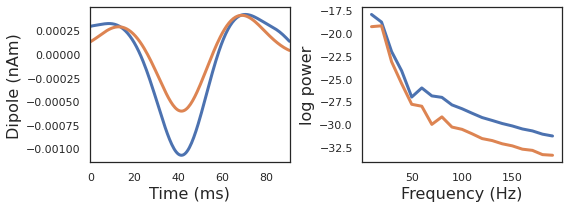

In [74]:
%matplotlib inline
labelsize = 16
offset_samples = 18

# Plot conditioning features    

plot_t_vec = t_vec - t_vec[offset_samples]
time_lim = [0, plot_t_vec[-1]]

x_cond_psd0, f = get_dataset_psd(x_cond_list[0], posterior_metadata['fs'])
x_cond_psd1, _ = get_dataset_psd(x_cond_list[1], posterior_metadata['fs'])

#x_cond_peak0 = get_dataset_peaks(x_cond_list[0], tstop)
#x_cond_peak1 = get_dataset_peaks(x_cond_list[1], tstop)

plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.plot(plot_t_vec, x_cond_list[0].squeeze(), linewidth=3)
plt.plot(plot_t_vec, x_cond_list[1].squeeze(), linewidth=3)
plt.xlabel('Time (ms)', fontsize=labelsize)
plt.xlim(time_lim)
plt.ylabel('Dipole (nAm)', fontsize=labelsize)

plt.subplot(1,2,2)
plt.plot(f, x_cond_psd0.squeeze(), linewidth=3)
plt.plot(f, x_cond_psd1.squeeze(), linewidth=3)
plt.xlabel('Frequency (Hz)', fontsize=labelsize)
#plt.xlim([f[0], f[-35]])
plt.ylabel('log power', fontsize=labelsize)

plt.tight_layout()

#plt.savefig('hnn_beta_posterior_compare_cond.svg')

In [75]:
prior = UniformPrior(parameters=list(prior_dict.keys()))
n_params = len(prior_dict)
limits = list(prior_dict.values())

# Collect plotting data outside loop
scatter_data_list = list()

input_type_list = ['pca30']
for plot_idx, input_type in enumerate(input_type_list):
    posterior_dict = posterior_state_dicts[input_type]
    state_dict = posterior_dict['posterior']
    n_params = posterior_dict['n_params']
    n_sims = posterior_dict['n_sims']
    input_dict = posterior_dict['input_dict']

    embedding_net =  input_dict['embedding_func'](**input_dict['embedding_dict'])

    print(f'Conditioning Feature: {input_type}')

    # Posterior scatter plot: get samples for conditoning waveform
    num_samples = 1000
    all_labels = list(prior_dict.keys())
    all_bounds = [param_dict['bounds'] for param_dict in prior_dict.values()]

    df_list, samples_list = list(), list()
    cond_name = ['Large', 'Small']
    for x_cond, cond_name in zip(x_cond_list, cond_name):
        load_info = {name: {'x_train': posterior_dict['input_dict']['feature_func'](x_orig), 
                            'x_cond': posterior_dict['input_dict']['feature_func'](x_cond)}
                     for name, posterior_dict in posterior_state_dicts.items()}
        posterior = load_posterior(state_dict=state_dict,
                                   x_infer=torch.tensor(load_info[input_type]['x_train'][:10,:]).float(),
                                   theta_infer=torch.tensor(theta_orig[:10,:]), prior=prior, embedding_net=embedding_net)

        samples = posterior.sample((num_samples,), x=torch.tensor(load_info[input_type]['x_cond'].squeeze()))
        samples_list.append(samples)
        samples_transformed = linear_scale_array(samples.numpy(), all_bounds)

        df_dict = {name: samples_transformed[:, idx] for idx, name in enumerate(all_labels)}
        df_dict['cond_name'] = np.repeat(cond_name, num_samples)

        df_temp = pd.DataFrame(df_dict)

        df_list.append(df_temp)
    df = pd.concat(df_list)
    
    scatter_data_list.append(df)




Conditioning Feature: pca30


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

pca30


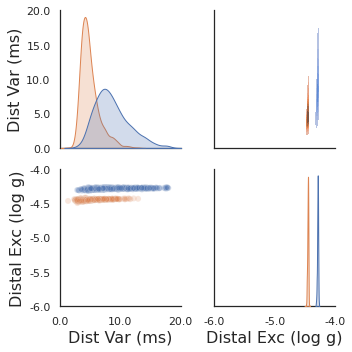

In [76]:
feature_idx = 0
print(input_type_list[feature_idx])

labelsize=16

param_labels = ['Dist Var (ms)', 'Distal Exc (log g)']

df = scatter_data_list[feature_idx]

all_bounds = [param_dict['bounds'] for param_dict in prior_dict.values()]
g = sns.PairGrid(df, vars=['dist_var', 'dist_exc'], hue='cond_name', diag_sharey=False, corner=False)
g.map_lower(sns.scatterplot, alpha=0.2)
g.map_upper(sns.kdeplot, fill=True)
g.map_diag(sns.kdeplot, fill=True)

for idx in range(2):    
    # Add space to visuzalize groundtruth tick marks at top
    y_diff = np.abs(all_bounds[idx][1] - all_bounds[idx][0])

    g.axes[idx, idx].set_xlim(all_bounds[idx])
    g.axes[idx, idx].set_ylim(all_bounds[idx])
    
    g.axes[idx,0].set_ylabel(param_labels[idx], fontsize=labelsize)
    g.axes[1,idx].set_xlabel(param_labels[idx], fontsize=labelsize)

for idx1 in range(2):
    for idx2 in range(2):
        if g.axes[idx1, idx2] != None:
            g.axes[idx1, idx2].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
            g.axes[idx1, idx2].xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
plt.tight_layout()
#plt.savefig('hnn_beta_posterior_compare.svg')

In [77]:
res_large = simulator(samples_list[0][:5])
res_small = simulator(samples_list[1][:5])

{'dist_var': 9.051612615585327, 'dist_exc': 5.083202589783817e-05}
joblib will run over 1 jobs
Building the NEURON model
[Done]
running trial 1 on 1 cores
Simulation time: 0.5 ms...
Simulation time: 10.0 ms...
Simulation time: 20.0 ms...
Simulation time: 30.0 ms...
Simulation time: 40.0 ms...
Simulation time: 50.0 ms...
Simulation time: 60.0 ms...
Simulation time: 70.0 ms...
Simulation time: 80.0 ms...
Simulation time: 90.0 ms...
Simulation time: 100.0 ms...
Simulation time: 110.0 ms...
Simulation time: 120.0 ms...
Simulation time: 130.0 ms...
Simulation time: 140.0 ms...
Simulation time: 150.0 ms...
Simulation time: 160.0 ms...
Simulation time: 170.0 ms...
Simulation time: 180.0 ms...
Simulation time: 190.0 ms...
Simulation time: 200.0 ms...
Simulation time: 210.0 ms...
Simulation time: 220.0 ms...
Simulation time: 230.0 ms...
Simulation time: 240.0 ms...
Simulation time: 250.0 ms...
Simulation time: 260.0 ms...
Simulation time: 270.0 ms...
Simulation time: 280.0 ms...
Simulation time

/home/ntolley/Jones_Lab/hnn_sbi_examples/notebooks/hnn_beta/../../code/utils.py:558: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x, dtype=torch.float32)


joblib will run over 1 jobs
Building the NEURON model
[Done]
running trial 1 on 1 cores
Simulation time: 0.5 ms...
Simulation time: 10.0 ms...
Simulation time: 20.0 ms...
Simulation time: 30.0 ms...
Simulation time: 40.0 ms...
Simulation time: 50.0 ms...
Simulation time: 60.0 ms...
Simulation time: 70.0 ms...
Simulation time: 80.0 ms...
Simulation time: 90.0 ms...
Simulation time: 100.0 ms...
Simulation time: 110.0 ms...
Simulation time: 120.0 ms...
Simulation time: 130.0 ms...
Simulation time: 140.0 ms...
Simulation time: 150.0 ms...
Simulation time: 160.0 ms...
Simulation time: 170.0 ms...
Simulation time: 180.0 ms...
Simulation time: 190.0 ms...
Simulation time: 200.0 ms...
Simulation time: 210.0 ms...
Simulation time: 220.0 ms...
Simulation time: 230.0 ms...
Simulation time: 240.0 ms...
Simulation time: 250.0 ms...
Simulation time: 260.0 ms...
Simulation time: 270.0 ms...
Simulation time: 280.0 ms...
Simulation time: 290.0 ms...
Simulation time: 300.0 ms...
Simulation time: 310.0 m

In [ ]:
plt.figure()
plt.subplot(1,2,1)
plt.plot(plot_t_vec, res_large[:,window_samples[0]:window_samples[1]].T * scale_factor, color='C0', alpha=0.5)
plt.plot(plot_t_vec, x_cond_list[0].T * scale_factor, linewidth=3)
plt.ylabel('Dipole (nAm)')
plt.xlabel('Time (ms)')
plt.ylim([-70, 40])
plt.title('Real Large BE PPC')

plt.subplot(1,2,2)
plt.plot(plot_t_vec, res_small[:,window_samples[0]:window_samples[1]].T * scale_factor, color='C1', alpha=0.5)
plt.plot(plot_t_vec, x_cond_list[1].T * scale_factor, linewidth=3, color='C1')
plt.title('Real Small BE PPC')

plt.ylabel('Dipole (nAm)')
plt.xlabel('Time (ms)')
plt.ylim([-70, 40])
plt.tight_layout()
